In [15]:
pip install snapml


In [46]:
# Import the libraries we need to use in this lab
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import mean_squared_error
import time
import warnings
import gc, sys
warnings.filterwarnings('ignore')

In [47]:
# read the input data
raw_data = pd.read_csv(r'M:\Ai engineer\yellow_tripdata_2019-06.csv')
print("There are " + str(len(raw_data)) + " observations in the dataset.")
print("There are " + str(len(raw_data.columns)) + " variables in the dataset.")

# display first rows in the dataset
raw_data.head()

There are 3936004 observations in the dataset.
There are 18 variables in the dataset.


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-06-01 00:55:13,2019-06-01 00:56:17,1.0,0.0,1.0,N,145.0,145.0,2.0,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0
1,1,2019-06-01 00:06:31,2019-06-01 00:06:52,1.0,0.0,1.0,N,262.0,263.0,2.0,2.5,3.0,0.5,0.00,0.0,0.3,6.30,2.5
2,1,2019-06-01 00:17:05,2019-06-01 00:36:38,1.0,4.4,1.0,N,74.0,7.0,2.0,17.5,0.5,0.5,0.00,0.0,0.3,18.80,0.0
3,1,2019-06-01 00:59:02,2019-06-01 00:59:12,0.0,0.8,1.0,N,145.0,145.0,2.0,2.5,1.0,0.5,0.00,0.0,0.3,4.30,0.0
4,1,2019-06-01 00:03:25,2019-06-01 00:15:42,1.0,1.7,1.0,N,113.0,148.0,1.0,9.5,3.0,0.5,2.65,0.0,0.3,15.95,2.5


There are 2712719 observations in the dataset.
There are 17 variables in the dataset.


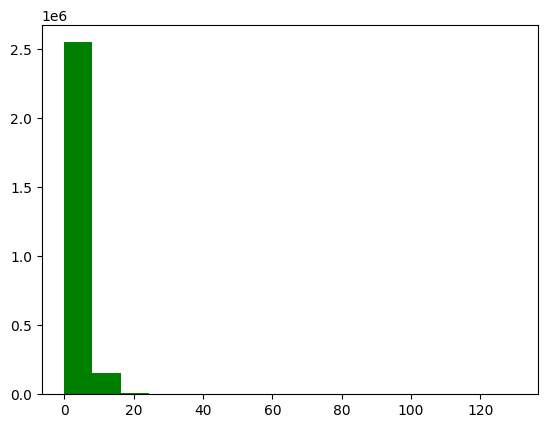

Minimum amount value is  0.01
Maximum amount value is  130.0
90% of the trips have a tip amount less or equal than  5.95


In [48]:
# some trips report 0 tip. it is assumed that these tips were paid in cash.
# for this study we drop all these rows
raw_data = raw_data[raw_data['tip_amount'] > 0]

# we also remove some outliers, namely those where the tip was larger than the fare cost
raw_data = raw_data[(raw_data['tip_amount'] <= raw_data['fare_amount'])]

# we remove trips with very large fare cost
raw_data = raw_data[((raw_data['fare_amount'] >=2) & (raw_data['fare_amount'] < 200))]

# we drop variables that include the target variable in it, namely the total_amount
clean_data = raw_data.drop(['total_amount'], axis=1)

# release memory occupied by raw_data as we do not need it anymore
# we are dealing with a large dataset, thus we need to make sure we do not run out of memory
del raw_data
gc.collect()

# print the number of trips left in the dataset
print("There are " + str(len(clean_data)) + " observations in the dataset.")
print("There are " + str(len(clean_data.columns)) + " variables in the dataset.")

plt.hist(clean_data.tip_amount.values, 16, histtype='bar', facecolor='g')
plt.show()

print("Minimum amount value is ", np.min(clean_data.tip_amount.values))
print("Maximum amount value is ", np.max(clean_data.tip_amount.values))
print("90% of the trips have a tip amount less or equal than ", np.percentile(clean_data.tip_amount.values, 90))

In [35]:

# Convert 'tpep_dropoff_datetime' and 'tpep_pickup_datetime' columns to datetime objects
clean_data['tpep_dropoff_datetime'] = pd.to_datetime(clean_data['tpep_dropoff_datetime'])
clean_data['tpep_pickup_datetime'] = pd.to_datetime(clean_data['tpep_pickup_datetime'])

# Extract pickup and dropoff hour
clean_data['pickup_hour'] = clean_data['tpep_pickup_datetime'].dt.hour
clean_data['dropoff_hour'] = clean_data['tpep_dropoff_datetime'].dt.hour

# Extract pickup and dropoff day of the week (0 = Monday, 6 = Sunday)
clean_data['pickup_day'] = clean_data['tpep_pickup_datetime'].dt.weekday
clean_data['dropoff_day'] = clean_data['tpep_dropoff_datetime'].dt.weekday

# Calculate trip time in seconds
clean_data['trip_time'] = (clean_data['tpep_dropoff_datetime'] - clean_data['tpep_pickup_datetime']).dt.total_seconds()

# Ideally use the full dataset for this exercise.
# However, if you run into out-of-memory issues due to the data size, reduce it.
# For instance, in this example, we use only the first 200,000 samples.
first_n_rows = 200000
clean_data = clean_data.head(first_n_rows)

In [36]:
# drop the pickup and dropoff datetimes
clean_data = clean_data.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1)

# some features are categorical, we need to encode them
# to encode them we use one-hot encoding from the Pandas package
get_dummy_col = ["VendorID","RatecodeID","store_and_fwd_flag","PULocationID", "DOLocationID","payment_type", "pickup_hour", "dropoff_hour", "pickup_day", "dropoff_day"]
proc_data = pd.get_dummies(clean_data, columns = get_dummy_col)

# release memory occupied by clean_data as we do not need it anymore
# we are dealing with a large dataset, thus we need to make sure we do not run out of memory
del clean_data
gc.collect()

318

In [49]:
# extract the labels from the dataframe
y = proc_data[['tip_amount']].values.astype('float32')

# drop the target variable from the feature matrix
proc_data = proc_data.drop(['tip_amount'], axis=1)

# get the feature matrix used for training
X = proc_data.values

# normalize the feature matrix
X = normalize(X, axis=1, norm='l1', copy=False)

# print the shape of the features matrix and the labels vector
print('X.shape=', X.shape, 'y.shape=', y.shape)

KeyError: "None of [Index(['tip_amount'], dtype='object')] are in the [columns]"

In [43]:
from sklearn.tree import DecisionTreeRegressor
from snapml import DecisionTreeRegressor as SnapDecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import time

# Assuming X and y are already defined
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Measure time for Scikit-Learn Decision Tree training
start_time = time.time()
sklearn_dt = DecisionTreeRegressor(max_depth=10, random_state=42)
sklearn_dt.fit(X_train, y_train)
sklearn_time = time.time() - start_time
print(f"Scikit-Learn Decision Tree Training Time: {sklearn_time:.2f} seconds")

# Measure time for Snap ML Decision Tree training
start_time = time.time()
snapml_dt = SnapDecisionTreeRegressor(max_depth=10, random_state=42, n_jobs=4)
snapml_dt.fit(X_train, y_train)
snapml_time = time.time() - start_time
print(f"Snap ML Decision Tree Training Time: {snapml_time:.2f} seconds")

# Calculate training speedup
training_speedup = sklearn_time / snapml_time
print(f'[Decision Tree Regressor] Snap ML vs. Scikit-Learn speedup: {training_speedup:.2f}x')

# Run inference using the Scikit-Learn model
sklearn_pred = sklearn_dt.predict(X_test)
sklearn_mse = mean_squared_error(y_test, sklearn_pred)
print(f'[Scikit-Learn] MSE score: {sklearn_mse:.3f}')

# Run inference using the Snap ML model
snapml_pred = snapml_dt.predict(X_test)
snapml_mse = mean_squared_error(y_test, snapml_pred)
print(f'[Snap ML] MSE score: {snapml_mse:.3f}')


Scikit-Learn Decision Tree Training Time: 19.82 seconds
Snap ML Decision Tree Training Time: 14.54 seconds
[Decision Tree Regressor] Snap ML vs. Scikit-Learn speedup: 1.36x
[Scikit-Learn] MSE score: 1.701
[Snap ML] MSE score: 1.639


In [ ]:
# Snap ML vs Scikit-Learn training speedup
training_speedup = sklearn_time/snapml_time
print('[Decision Tree Regressor] Snap ML vs. Scikit-Learn speedup : {0:.2f}x '.format(training_speedup))

# run inference using the sklearn model
sklearn_pred = sklearn_dt.predict(X_test)

# evaluate mean squared error on the test dataset
sklearn_mse = mean_squared_error(y_test, sklearn_pred)
print('[Scikit-Learn] MSE score : {0:.3f}'.format(sklearn_mse))

# run inference using the Snap ML model
snapml_pred = snapml_dt.predict(X_test)

# evaluate mean squared error on the test dataset
snapml_mse = mean_squared_error(y_test, snapml_pred)
print('[Snap ML] MSE score : {0:.3f}'.format(snapml_mse))